In [1]:
!pip install tensorflow-datasets
import tensorflow_datasets as tfds

     |████████████████████████████████| 3.9 MB 7.9 MB/s eta 0:00:01     |██████████████▌                 | 1.8 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 829 kB 22.6 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 33.7 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=a8052a99a172f6649bc9ffcdd9ddd23fa449a0406a2ece643076fe9769441cab
  Stored in directory: /home/davidvdm/.cache/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=5c35a2dd844d45a34b8a39c571c40e3502e57bf0dd736eb8a95559fe1b167916
  Stored in directory: /home/davidvdm/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built future promise


In [2]:
import os
import requests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/project/svd-kernels')
from src.optimizers import SVDAdam
from src.callbacks import OrthogonalityTracker, ConditioningTracker
from src.layers import SVDDense

In [4]:
plt.style.use('dark_background')

# NLP performance benchmarking

### Data loading

In [5]:
ds, ds_info = tfds.load(name='ted_hrlr_translate/pt_to_en', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-train.tfrecord...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-validation.tfrecord...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-test.tfrecord...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /home/davidvdm/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='/home/davidvdm/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1193, num_shards=1>,
    },
    citation="""@

### Visualization

In [14]:
tfds.as_dataframe(ds['train'].take(2))

,en,pt
0,"b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'","b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'"
1,b'but what if it were active ?',b'mas e se estes fatores fossem ativos ?'


### Preprocessing

In [26]:
# Parameters
num_words = 10000
splits = ['train', 'test', 'validation']

# Fit english tokenizer
tokenizer_en = tf.keras.preprocessing.text.Tokenizer(
    num_words=num_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=0
)

# Fit portuguese tokenizer
tokenizer_pt = tf.keras.preprocessing.text.Tokenizer(
    num_words=num_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=0
)

for split in splits:
    tokenizer_en.fit_on_texts((s.numpy().decode('utf-8') for s in ds[split].map(lambda d: d['en'])))
    tokenizer_pt.fit_on_texts((s.numpy().decode('utf-8') for s in ds[split].map(lambda d: d['pt'])))

In [31]:
# Convert texts to tokens
x_train = tokenizer_en.texts_to_sequences((s.numpy().decode('utf-8') for s in ds['train'].map(lambda d: d['en'])))
y_train = tokenizer_pt.texts_to_sequences((s.numpy().decode('utf-8') for s in ds['train'].map(lambda d: d['pt'])))

x_test = tokenizer_en.texts_to_sequences((s.numpy().decode('utf-8') for s in ds['test'].map(lambda d: d['en'])))
y_test = tokenizer_pt.texts_to_sequences((s.numpy().decode('utf-8') for s in ds['test'].map(lambda d: d['pt'])))

In [38]:
type(x_train[0][0])

int

### Data pipeline

In [50]:
# Parameters
batch_size = 32
buffer_size = batch_size * 128
# Make dataset from tokenized sequences
dataset = tf.data.Dataset.from_generator(
    lambda: ((x, y) for x, y in zip(x_train, y_train)), 
    output_shapes=([None], [None]), 
    output_types=(tf.int32, tf.int32)).padded_batch(batch_size, padding_values=(-1, -1))
# Check shapes
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(32, 36) (32, 39)


### Model

In [9]:
# Parameters for model architecture
units = 256
rank = 16
n_classes = 10
activation = 'elu'

In [10]:
def build_model(units, rank):
    # Make input layer
    inputs = tf.keras.Input(shape=x.shape[1:])
    # Convolutional layer
    hidden = tf.keras.layers.Conv2D(32, kernel_size=(7, 7), activation=activation)(inputs)
    # bottleneck
    hidden = tf.keras.layers.Conv2D(64, kernel_size=(1, 1), activation=activation)(hidden)
    # Maximum pooling
    hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
    # Convolutional layer one
    skip = tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same')(hidden)
    # Convolutional layer connected
    hidden += tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same')(skip)
    # Maximum pooling
    hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
    # Convolutional layer one
    skip = tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same')(hidden)
    # Convolutional layer connected
    hidden += tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same')(skip)
    # Maximum pooling
    hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
    # Flatten
    hidden = tf.keras.layers.Flatten()(hidden)
    # Fully connected
    if rank is None:
        hidden = tf.keras.layers.Dense(units, activation=activation)(hidden)
    else:
        hidden = SVDDense(units, rank, activation=activation)(hidden)
    # Dropout
    hidden = tf.keras.layers.Dropout(0.25)(hidden)
    # Projection layer
    outputs = tf.keras.layers.Dense(n_classes, 'softmax')(hidden)
    # Make & compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
# Number of epochs
epochs = 5
# Learning rates
learning_rate = 10e-5
nu = 10e-5
# acceleration parameters
beta = 0.9
gamma = 0.999

# Loss and accuracy
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=1)

In [12]:
model = build_model(units, None)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Early stopping
callbacks = [early_stopping]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/5
1563/1563 [==============================] - 196s 124ms/step - loss: 1.8032 - sparse_categorical_accuracy: 0.3457 - val_loss: 1.3430 - val_sparse_categorical_accuracy: 0.5205
Epoch 2/5
1563/1563 [==============================] - 190s 122ms/step - loss: 1.3116 - sparse_categorical_accuracy: 0.5354 - val_loss: 1.1649 - val_sparse_categorical_accuracy: 0.5879
Epoch 3/5
1563/1563 [==============================] - 188s 120ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.5970 - val_loss: 1.0745 - val_sparse_categorical_accuracy: 0.6214
Epoch 4/5
1563/1563 [==============================] - 196s 125ms/step - loss: 1.0541 - sparse_categorical_accuracy: 0.6318 - val_loss: 1.0288 - val_sparse_categorical_accuracy: 0.6382
Epoch 5/5
1563/1563 [==============================] - 187s 120ms/step - loss: 0.9828 - sparse_categorical_accuracy: 0.6600 - val_loss: 0.9833 - val_sparse_categorical_accuracy: 0.6550


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 64)   2112        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [15]:
model = build_model(units, rank)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Callbacks
callbacks = [early_stopping]
# Add trackers to callbacks
callbacks += [orthogonality_tracker, conditioning_tracker]
# Train model
history_ = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/5
1563/1563 [==============================] - 200s 127ms/step - loss: 1.9185 - sparse_categorical_accuracy: 0.4368 - val_loss: 1.4843 - val_sparse_categorical_accuracy: 0.4560
Epoch 2/5
1563/1563 [==============================] - 195s 125ms/step - loss: 1.4187 - sparse_categorical_accuracy: 0.4830 - val_loss: 1.2910 - val_sparse_categorical_accuracy: 0.5306
Epoch 3/5
1563/1563 [==============================] - 198s 126ms/step - loss: 1.2601 - sparse_categorical_accuracy: 0.5458 - val_loss: 1.1727 - val_sparse_categorical_accuracy: 0.5812
Epoch 4/5
1563/1563 [==============================] - 211s 135ms/step - loss: 1.1444 - sparse_categorical_accuracy: 0.5952 - val_loss: 1.1043 - val_sparse_categorical_accuracy: 0.6112
Epoch 5/5
1563/1563 [==============================] - 222s 142ms/step - loss: 1.0654 - sparse_categorical_accuracy: 0.6271 - val_loss: 1.0564 - val_sparse_categorical_accuracy: 0.6319


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 26, 26, 32)   4736        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 26, 26, 64)   2112        conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 13, 13, 64)   0           conv2d_7[0][0]                   
____________________________________________________________________________________________

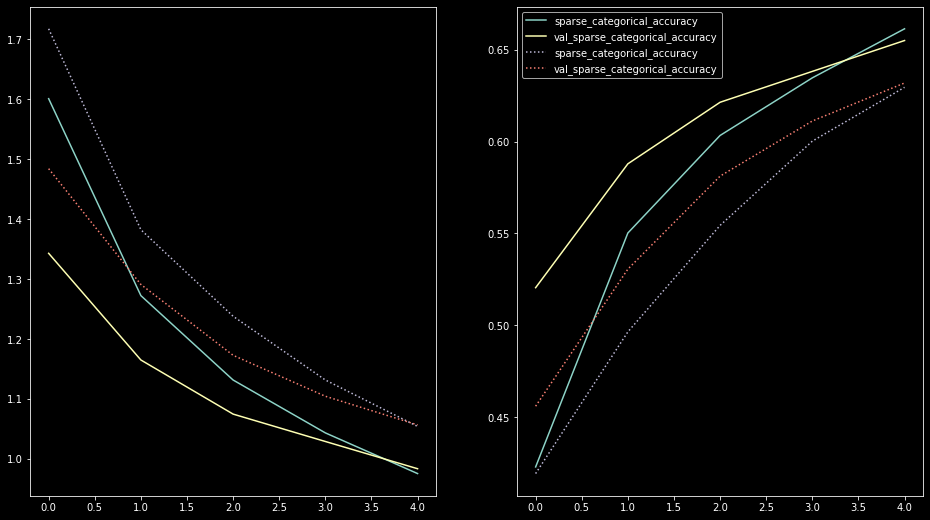

In [17]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
for key, value in history_.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key, linestyle='dotted')
plt.legend()
plt.show()

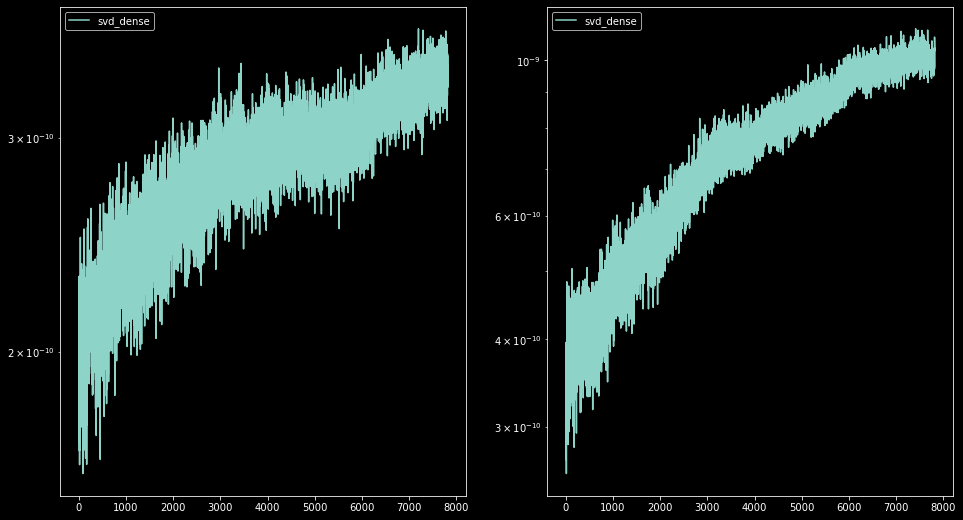

In [18]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        axes[0].plot(orthogonality_tracker.kappa[layer.name]['u'], label=layer.name)
        axes[1].plot(orthogonality_tracker.kappa[layer.name]['v'], label=layer.name)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

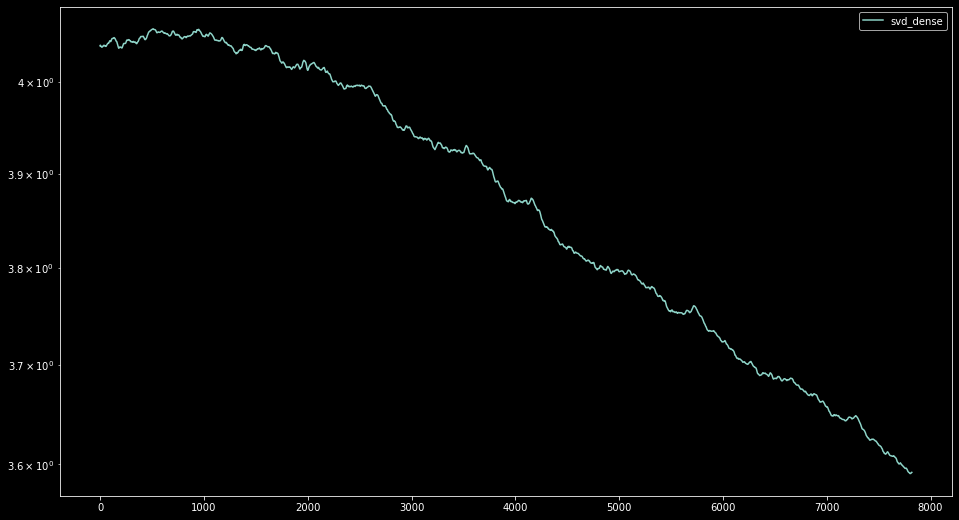

In [19]:
fig, axes = plt.subplots(1,1, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(conditioning_tracker.kappa[layer.name], label=layer.name)
plt.yscale('log')
plt.legend()
plt.show()

### Rank dependence

In [59]:
ranks = [16, 32, 64, 128]

In [62]:
# empty dicts for models & histories
models_rank = {}
histories_rank = {}
trackers_rank = {}

for rank in ranks:
    # Make trackers
    orthogonality_tracker = OrthogonalityTracker(on_batch=True)
    conditioning_tracker = ConditioningTracker(on_batch=True)
    # Make model
    model = build_model(units, rank)
    # SVD optimizer
    optimizer = SVDAdam(model, learning_rate, nu, beta, gamma)
    # Compile model
    model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
    # Callbacks
    callbacks = [early_stopping]
    # Add trackers to callbacks
    callbacks += [orthogonality_tracker, conditioning_tracker]
    # Train model
    histories_rank[rank] = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
    models_rank[rank] = model
    trackers_rank[rank] = callbacks

Epoch 1/5
1875/1875 [==============================] - 153s 80ms/step - loss: 0.6911 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.1019 - val_sparse_categorical_accuracy: 0.9669
Epoch 2/5
1875/1875 [==============================] - 151s 80ms/step - loss: 0.0988 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.0586 - val_sparse_categorical_accuracy: 0.9798
Epoch 3/5
1875/1875 [==============================] - 151s 80ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.0484 - val_sparse_categorical_accuracy: 0.9843
Epoch 4/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9844 - val_loss: 0.0449 - val_sparse_categorical_accuracy: 0.9850
Epoch 5/5
1875/1875 [==============================] - 160s 85ms/step - loss: 0.0412 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.0396 - val_sparse_categorical_accuracy: 0.9871
Epoch 1/5
1875/1875 [==============================] - 166s 87ms/step - loss: 0.

InvalidArgumentError:  Input is not invertible.
	 [[node svd_adam_16/MatrixInverse_1 (defined at /project/svd-kernels/src/optimizers/utils.py:75) ]] [Op:__inference_train_function_4859044]

Errors may have originated from an input operation.
Input Source operations connected to node svd_adam_16/MatrixInverse_1:
 svd_adam_16/add_16 (defined at /project/svd-kernels/src/optimizers/utils.py:73)

Function call stack:
train_function


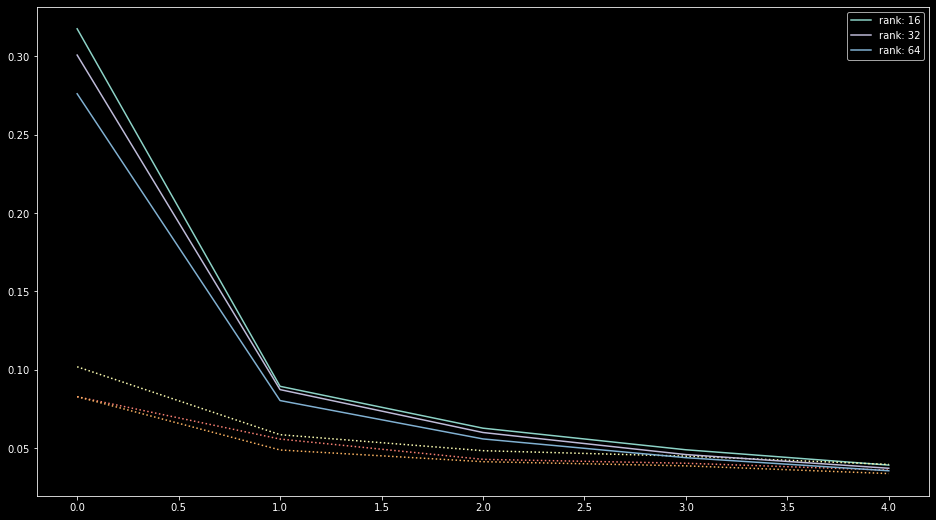

In [67]:
plt.figure(figsize=(16, 9))
for rank, history in histories_rank.items():
    plt.plot(history.history['loss'], label=f'rank: {rank}')
    plt.plot(history.history['val_loss'], linestyle='dotted')
plt.legend()
plt.show()

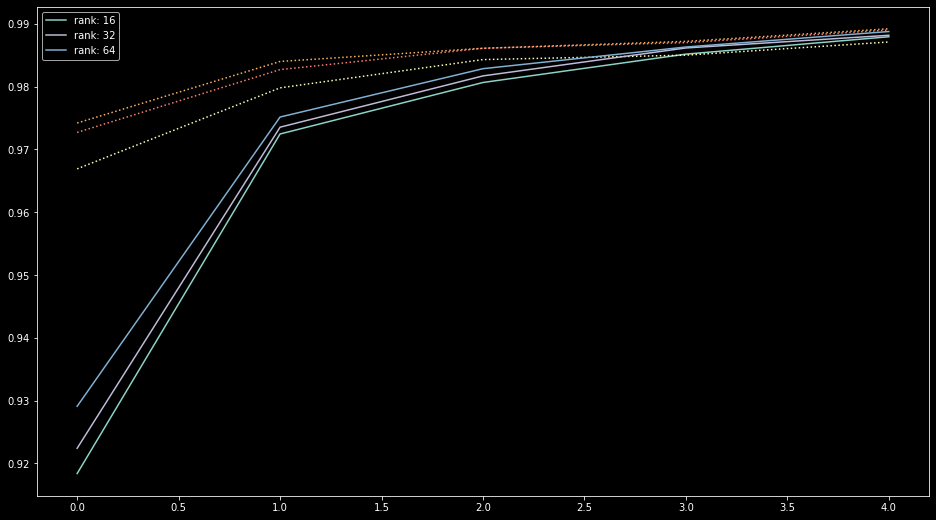

In [69]:
plt.figure(figsize=(16, 9))
for rank, history in histories_rank.items():
    plt.plot(history.history['sparse_categorical_accuracy'], label=f'rank: {rank}')
    plt.plot(history.history['val_sparse_categorical_accuracy'], linestyle='dotted')
plt.legend()
plt.show()

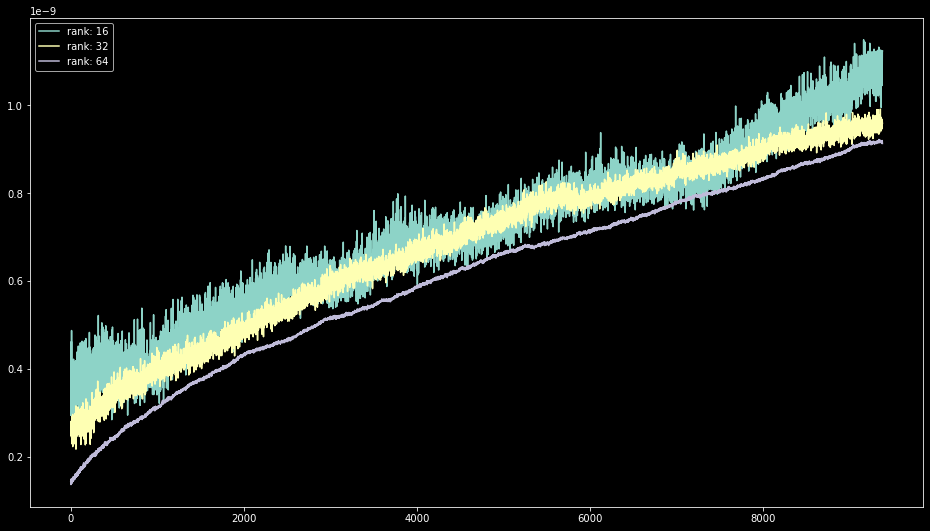

In [77]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    ortho = track[1].kappa
    plt.plot(ortho[list(ortho.keys())[0]]['u'], label=f'rank: {rank}')
plt.legend()
plt.show()

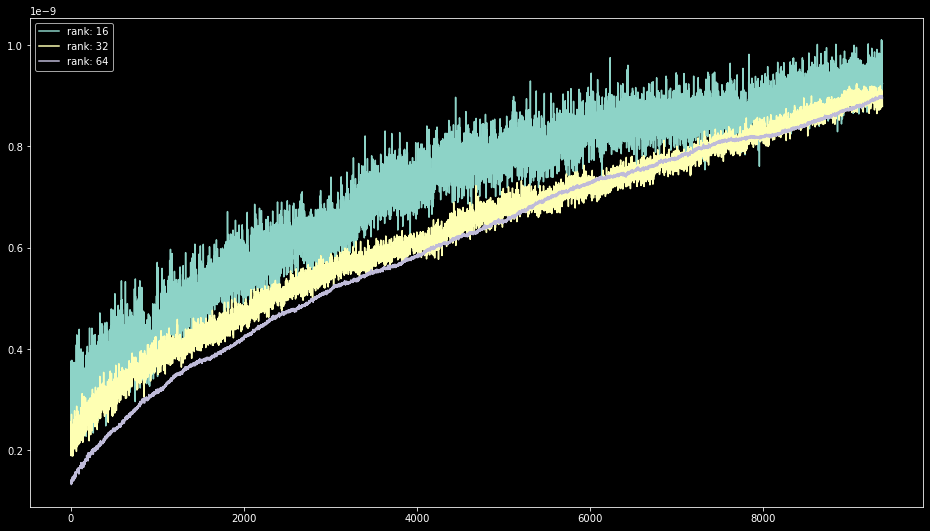

In [78]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    ortho = track[1].kappa
    plt.plot(ortho[list(ortho.keys())[0]]['v'], label=f'rank: {rank}')
plt.legend()
plt.show()

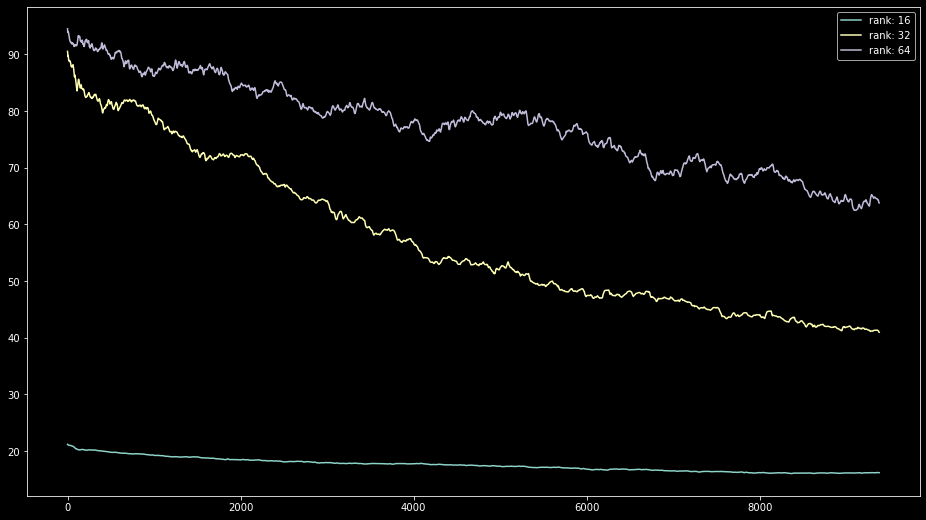

In [80]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    cond = track[2].kappa
    plt.plot(cond[list(cond.keys())[0]], label=f'rank: {rank}')
plt.legend()
plt.show()

### Fully convolutional

In [55]:
# Make input layer
inputs = tf.keras.Input(shape=x.shape[1:])
# Convolutional layer
hidden = tf.keras.layers.Conv2D(32, kernel_size=(7, 7), activation=activation)(inputs)
# bottleneck
hidden = tf.keras.layers.Conv2D(64, kernel_size=(1, 1), activation=activation)(hidden)
# Maximum pooling
hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
# Convolutional layer one
skip = tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same')(hidden)
# Convolutional layer connected
hidden += tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same')(skip)
# Maximum pooling
hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
# Convolutional layer one
skip = tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same')(hidden)
# Convolutional layer connected
hidden += tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same')(skip)
# Maximum pooling
hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
# Flatten
hidden = tf.keras.layers.Flatten()(hidden)
# Dropout
hidden = tf.keras.layers.Dropout(0.25)(hidden)
# Projection layer
outputs = tf.keras.layers.Dense(n_classes, 'softmax')(hidden)
# Make & compile model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [56]:
# Number of epochs
epochs = 5
# Learning rates
learning_rate = 10e-5
nu = 10e-5
# acceleration parameters
beta = 0.9
gamma = 0.999

# Loss and accuracy
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=1)

In [57]:
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Early stopping
callbacks = [early_stopping]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 147s 78ms/step - loss: 0.7498 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.0900 - val_sparse_categorical_accuracy: 0.9714
Epoch 2/5
1875/1875 [==============================] - 146s 78ms/step - loss: 0.1203 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.0668 - val_sparse_categorical_accuracy: 0.9785
Epoch 3/5
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0806 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.0460 - val_sparse_categorical_accuracy: 0.9854
Epoch 4/5
1875/1875 [==============================] - 142s 76ms/step - loss: 0.0628 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0398 - val_sparse_categorical_accuracy: 0.9875
Epoch 5/5
1875/1875 [==============================] - 143s 76ms/step - loss: 0.0495 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.0310 - val_sparse_categorical_accuracy: 0.9899


In [58]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 22, 22, 32)   1600        input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 22, 22, 64)   2112        conv2d_52[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 11, 11, 64)   0           conv2d_53[0][0]                  
____________________________________________________________________________________________